# **Group 4 Data Mining And Wrangling Test2**

### **Data source:** *https://www.imdb.com/chart/top/*
#### We used used different methods to get the get the data but we concluded with the *Top 250 Movies* from IMDB using Scrapy and spider

##### Load the data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import missingno as mns 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import requests
import json
from datetime import date
from collections import Counter
from wordcloud import WordCloud


### Since we saved the dataset as a JSON file, We had to convert it to csv format removing the the [] and [[]] formats (lists and nested lists)

In [2]:

# Load the JSON file
json_file_path = "IMDB_250_movies.json"

with open(json_file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Convert list values to plain values
for movie in data:
    for key, value in movie.items():
        if isinstance(value, list):
            if all(isinstance(i, list) for i in value):  # If nested lists exist, flatten them
                movie[key] = ", ".join([", ".join(map(str, sublist)) for sublist in value])
            else:
                movie[key] = ", ".join(map(str, value))

# Convert to DataFrame
df = pd.DataFrame(data)

# Save as CSV
csv_file_path = "IMDB_250_movies.csv"
df.to_csv(csv_file_path, index=False, encoding="utf-8")

csv_file_path


'IMDB_250_movies.csv'

#### Reading the csv Dataset 

In [3]:
## reading the csv dataset 
df = pd.read_csv("IMDB_250_movies.csv")
df.head(6)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...
4,12 Angry Men,5,"Crime, Drama",10,4,1957,1:36:00,9.0,916939,The jury in a New York City murder trial is fr...
5,The Lord of the Rings: The Return of the King,6,"Adventure, Drama, Fantasy",17,12,2003,3:21:00,9.0,2063799,Gandalf and Aragorn lead the World of Men agai...


## **Exploratory Data Analysis**

In [4]:
## checking the shape of the dataset for information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          250 non-null    object 
 1   movie_rank     250 non-null    int64  
 2   genres         250 non-null    object 
 3   release_day    250 non-null    int64  
 4   release_month  250 non-null    int64  
 5   release_year   250 non-null    int64  
 6   movie_length   250 non-null    object 
 7   rating         250 non-null    float64
 8   vote_count     250 non-null    int64  
 9   description    250 non-null    object 
dtypes: float64(1), int64(5), object(4)
memory usage: 19.7+ KB


### Now we can use the OMDB API to get the other attributes of the dataset i.e. Main Actors, Budget, Box Office Gross, and Awards

In [5]:
# OMDb API Key
OMDB_API_KEY = "60fded84"

# Function to fetch movie details from OMDb API
def fetch_movie_details(title):
    url = f"http://www.omdbapi.com/?t={title}&apikey={OMDB_API_KEY}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        
        # Check if the response is valid
        if data.get("Response") == "True":
            return {
                "title": data.get("Title", title),  # Ensure title matches
                "Cast (Main Actors)": data.get("Actors", "N/A"),
                "Budget": "N/A",  # OMDb does not provide budget info
                "Box Office Gross": data.get("BoxOffice", "N/A"),
                "Awards": data.get("Awards", "N/A")
            }
    
    # If no valid response, return empty data
    return {
        "title": title,
        "Cast (Main Actors)": "N/A",
        "Budget": "N/A",
        "Box Office Gross": "N/A",
        "Awards": "N/A"
    }

# Load your existing CSV file
existing_csv = "IMDB_250_movies.csv"
df = pd.read_csv(existing_csv)

# Fetch details for each movie
additional_data = [fetch_movie_details(title) for title in df["title"]]

# Convert the fetched data into a DataFrame
extra_df = pd.DataFrame(additional_data)

# Merge with the existing DataFrame
df = df.merge(extra_df, on="title", how="left")

# Save updated data
new_df_path = "Final_IMDB_250_movies_with_OMDB.csv"
df.to_csv(new_df_path, index=False, encoding="utf-8")

print(f"Updated CSV saved at: {new_df_path}")


Updated CSV saved at: Final_IMDB_250_movies_with_OMDB.csv


## **Cleaning Data** 

In [6]:
df1 = pd.read_csv("Final_IMDB_250_movies_with_OMDB.csv")

df1.columns


Index(['title', 'movie_rank', 'genres', 'release_day', 'release_month',
       'release_year', 'movie_length', 'rating', 'vote_count', 'description',
       'Cast (Main Actors)', 'Budget', 'Box Office Gross', 'Awards'],
      dtype='object')

## **Visualizing the Missing Values**

<Axes: >

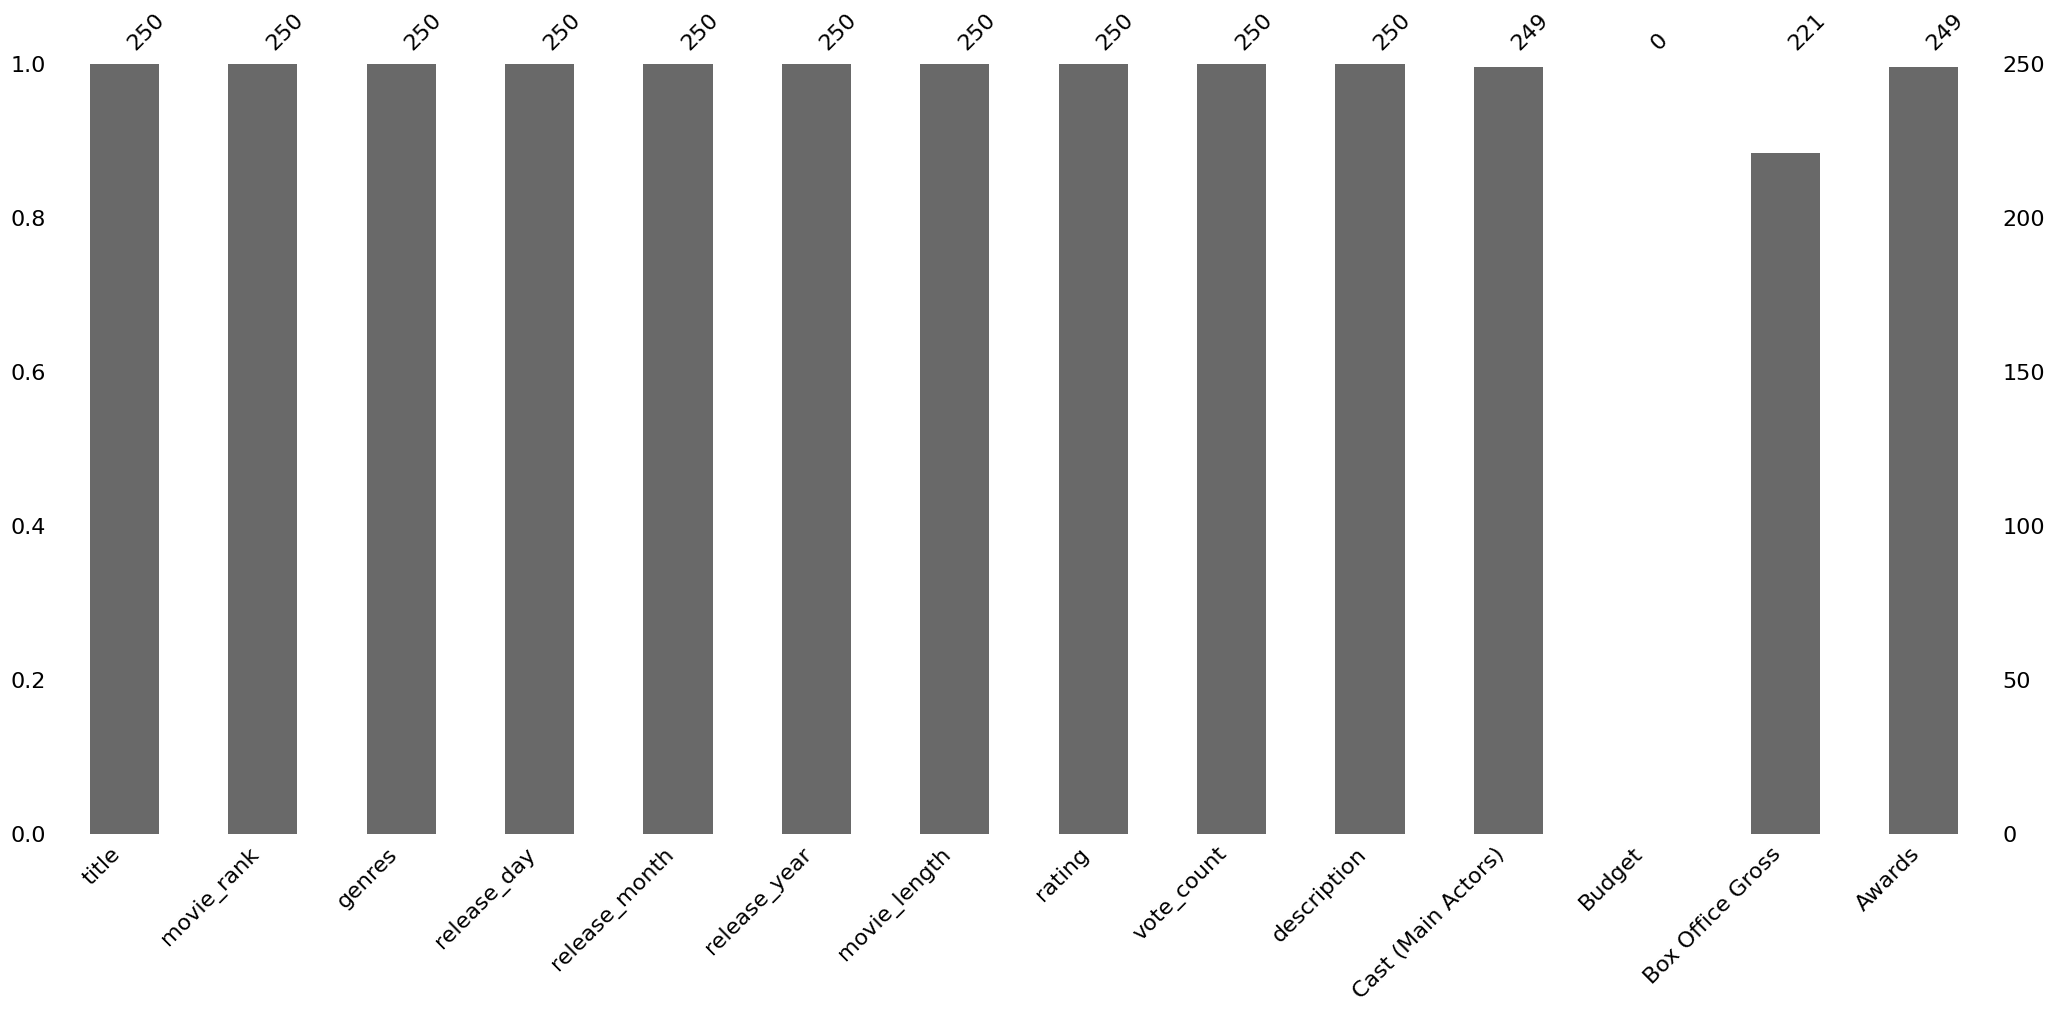

In [7]:
#### checking for missing values in the Box Office column
mns.bar(df1)

In [8]:
#### checking for missing values in the Box Office column
missing_values = df1.isnull().sum()

missing_values

title                   0
movie_rank              0
genres                  0
release_day             0
release_month           0
release_year            0
movie_length            0
rating                  0
vote_count              0
description             0
Cast (Main Actors)      1
Budget                250
Box Office Gross       29
Awards                  1
dtype: int64

In [9]:
### Dropping the Budget column
#The Budget column is not necessary for the analysis since it is only missing values, so we can drop it from the data frame.

df2 = df1.drop(columns=["Budget"])

df2.columns


Index(['title', 'movie_rank', 'genres', 'release_day', 'release_month',
       'release_year', 'movie_length', 'rating', 'vote_count', 'description',
       'Cast (Main Actors)', 'Box Office Gross', 'Awards'],
      dtype='object')

In [10]:
## checking the missing values in the dataset

df2.isnull().sum()

title                  0
movie_rank             0
genres                 0
release_day            0
release_month          0
release_year           0
movie_length           0
rating                 0
vote_count             0
description            0
Cast (Main Actors)     1
Box Office Gross      29
Awards                 1
dtype: int64

In [11]:
### Dropping the missing values
#Since the missing values are few, we can drop them from the dataset.
df3 = df2.dropna()



In [12]:
df3.head(6)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total
5,The Lord of the Rings: The Return of the King,6,"Adventure, Drama, Fantasy",17,12,2003,3:21:00,9.0,2063799,Gandalf and Aragorn lead the World of Men agai...,"Elijah Wood, Viggo Mortensen, Ian McKellen","$381,878,219",Won 11 Oscars. 215 wins & 124 nominations total
6,Schindler's List,7,"Biography, Drama, History",4,2,1993,3:15:00,9.0,1512153,"In German-occupied Poland during World War II,...","Liam Neeson, Ralph Fiennes, Ben Kingsley","$96,898,818",Won 7 Oscars. 91 wins & 49 nominations total


In [13]:
# checking the missing values in the dataset again
df3.isna().sum()


title                 0
movie_rank            0
genres                0
release_day           0
release_month         0
release_year          0
movie_length          0
rating                0
vote_count            0
description           0
Cast (Main Actors)    0
Box Office Gross      0
Awards                0
dtype: int64

## **Now we can save the data as a new dataset**

In [14]:
# saving df3 to a new file
df3.to_csv("IMDB_250_movies_cleaned2.csv", index=False)


In [27]:
### Loading the cleaned data
cleaned_data = pd.read_csv('IMDB_250_movies_cleaned2.csv')
cleaned_data.head(4)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total


### Converting the release_day, month, and year to strings

In [28]:
cleaned_data[['release_day','release_month','release_year']] = cleaned_data[['release_day','release_month','release_year']].astype('str')

In [30]:
cleaned_data.dtypes

title                  object
movie_rank              int64
genres                 object
release_day            object
release_month          object
release_year           object
movie_length           object
rating                float64
vote_count              int64
description            object
Cast (Main Actors)     object
Box Office Gross       object
Awards                 object
dtype: object

### Now convert the release day, month, and year to day-month-year

In [32]:
cleaned_data['date'] = pd.to_datetime(cleaned_data['release_year'] + '-' +  cleaned_data['release_month'] + '-'+ cleaned_data['release_day'])
cleaned_data['date']

0     1994-10-14
1     1972-03-24
2     2008-07-18
3     1974-12-18
4     2003-12-17
         ...    
216   2007-10-19
217   1993-02-12
218   2016-09-17
219   2011-08-10
220   2000-04-13
Name: date, Length: 221, dtype: datetime64[ns]

In [33]:
cleaned_data.head(4)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards,date
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18


### convert the release_month to the month name

In [34]:
cleaned_data['Release_Month_name'] = cleaned_data.date.dt.month_name()
cleaned_data.head(4)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards,date,Release_Month_name
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14,October
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24,March
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18,July
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18,December


### Getting the release_week_day

In [35]:

cleaned_data['Release_week_day'] = cleaned_data.date.dt.day_name()

In [36]:
## viewing the dataframe
cleaned_data.head(4)

,title,movie_rank,genres,release_day,release_month,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards,date,Release_Month_name,Release_week_day
0,The Shawshank Redemption,1,Drama,14,10,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14,October,Friday
1,The Godfather,2,"Crime, Drama",24,3,1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24,March,Friday
2,The Dark Knight,3,"Action, Crime, Drama",18,7,2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18,July,Friday
3,The Godfather Part II,4,"Crime, Drama",18,12,1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18,December,Wednesday


In [37]:
## column names
cleaned_data.columns

Index(['title', 'movie_rank', 'genres', 'release_day', 'release_month',
       'release_year', 'movie_length', 'rating', 'vote_count', 'description',
       'Cast (Main Actors)', 'Box Office Gross', 'Awards', 'date',
       'Release_Month_name', 'Release_week_day'],
      dtype='object')

### Droping the release day, month since we created a new column of day-month-year and movie_rank because its just a count

In [39]:
cleaned_reformed = cleaned_data.drop(columns = ['release_day'])
cleaned_reformed = cleaned_reformed.drop(columns=['movie_rank'])
cleaned_reformed = cleaned_reformed.drop(columns=['release_month'])
cleaned_reformed.head(6)

,title,genres,release_year,movie_length,rating,vote_count,description,Cast (Main Actors),Box Office Gross,Awards,date,Release_Month_name,Release_week_day
0,The Shawshank Redemption,Drama,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14,October,Friday
1,The Godfather,"Crime, Drama",1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24,March,Friday
2,The Dark Knight,"Action, Crime, Drama",2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18,July,Friday
3,The Godfather Part II,"Crime, Drama",1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18,December,Wednesday
4,The Lord of the Rings: The Return of the King,"Adventure, Drama, Fantasy",2003,3:21:00,9.0,2063799,Gandalf and Aragorn lead the World of Men agai...,"Elijah Wood, Viggo Mortensen, Ian McKellen","$381,878,219",Won 11 Oscars. 215 wins & 124 nominations total,2003-12-17,December,Wednesday
5,Schindler's List,"Biography, Drama, History",1993,3:15:00,9.0,1512153,"In German-occupied Poland during World War II,...","Liam Neeson, Ralph Fiennes, Ben Kingsley","$96,898,818",Won 7 Oscars. 91 wins & 49 nominations total,1993-02-04,February,Thursday


In [40]:
## renaming the description column to Synopsis
cleaned_reformed.rename(columns={'description':'Synopsis'},inplace=True)
cleaned_reformed.head(4)


,title,genres,release_year,movie_length,rating,vote_count,Synopsis,Cast (Main Actors),Box Office Gross,Awards,date,Release_Month_name,Release_week_day
0,The Shawshank Redemption,Drama,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14,October,Friday
1,The Godfather,"Crime, Drama",1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24,March,Friday
2,The Dark Knight,"Action, Crime, Drama",2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18,July,Friday
3,The Godfather Part II,"Crime, Drama",1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18,December,Wednesday


## **Question 2 Part One**

In [41]:
## Most common genres
genre_data = cleaned_reformed.groupby(['genres'],as_index=None,observed=True)['genres'].agg({'count'})
genre_data

,genres,count
0,"Action, Adventure",2
1,"Action, Adventure, Drama",2
2,"Action, Adventure, Fantasy",5
3,"Action, Adventure, Horror",1
4,"Action, Adventure, Sci-Fi",7
...,...,...
97,"Horror, Mystery, Thriller",1
98,"Horror, Sci-Fi",1
99,"Mystery, Romance, Thriller",1
100,"Mystery, Thriller",1


In [42]:
## Extracting  most released genres
# The most released genres are below
genre_data.loc[genre_data['count'] >= 7][['genres','count']]

,genres,count
4,"Action, Adventure, Sci-Fi",7
34,"Animation, Adventure, Comedy",7
48,"Biography, Drama, History",8
63,"Crime, Drama",11
66,"Crime, Drama, Mystery",8
71,Drama,16


#### Hence the top released genres are `Drama`, `crime,Drama`, `Biography, Drama, History`,`Animation, Adventure, Comedy` and `Action, Adventure, Sci-Fi`

Text(0.5, 1.0, 'A Countplot Showing The Most Released Genres')

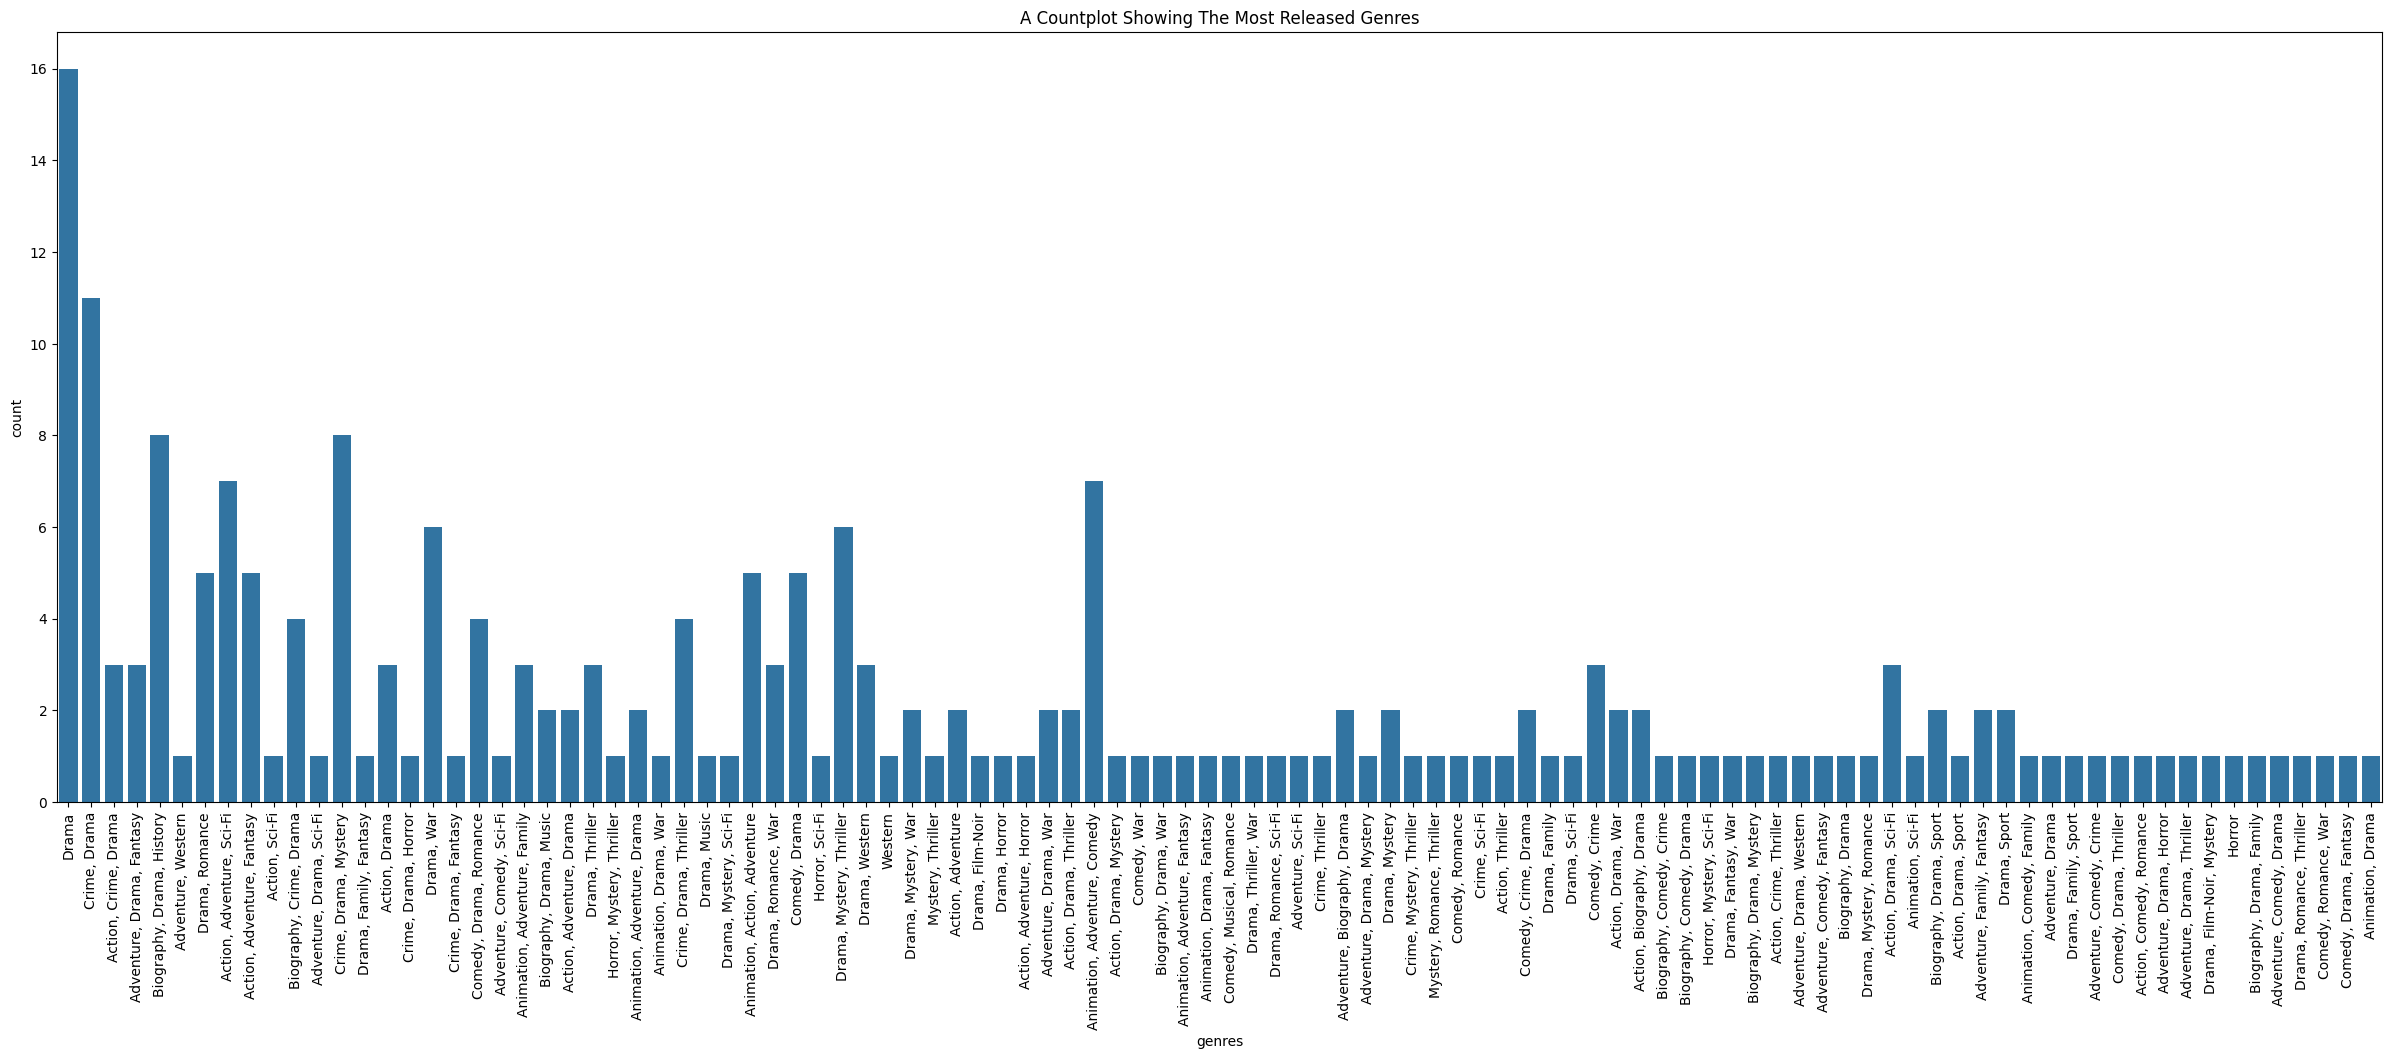

In [43]:
## A countplot showing the most release'd genres
plt.figure(figsize=(30,10))
sns.countplot(data=cleaned_reformed,x='genres')
plt.xticks(rotation = 90)
plt.title('a countplot showing the most released genres'.title())

In [44]:
# Split and count genre occurrences
all_genres = cleaned_reformed['genres'].dropna().str.split(', ').sum()
genre_counts = Counter(all_genres)

# Identify the most frequent genre
most_frequent_genre = genre_counts.most_common(1)[0]
most_frequent_genre


('Drama', 159)

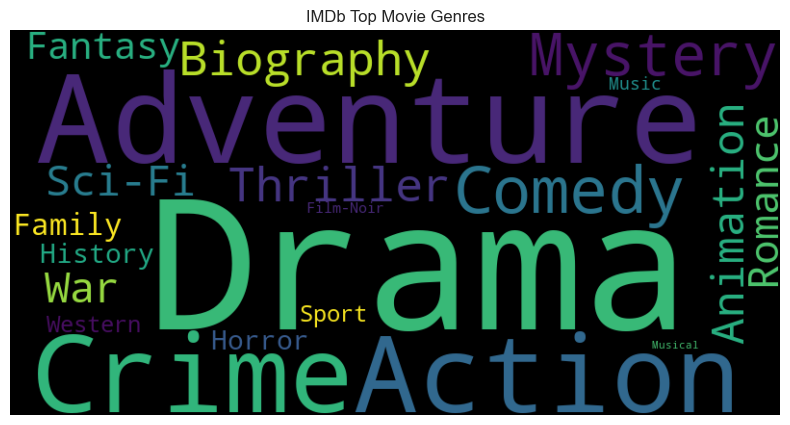

In [56]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis')
wordcloud.generate_from_frequencies(genre_counts)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('IMDb Top Movie Genres')
plt.show()

## **Question 2 Part 2**

In [58]:
average_rating = cleaned_reformed.agg({'rating':'mean'})
average_rating

rating    8.31267
dtype: float64

## **Question 2 Part 3**

In [57]:
## converting the release_year to integer
cleaned_reformed['release_year'] = cleaned_reformed['release_year'].astype(int)

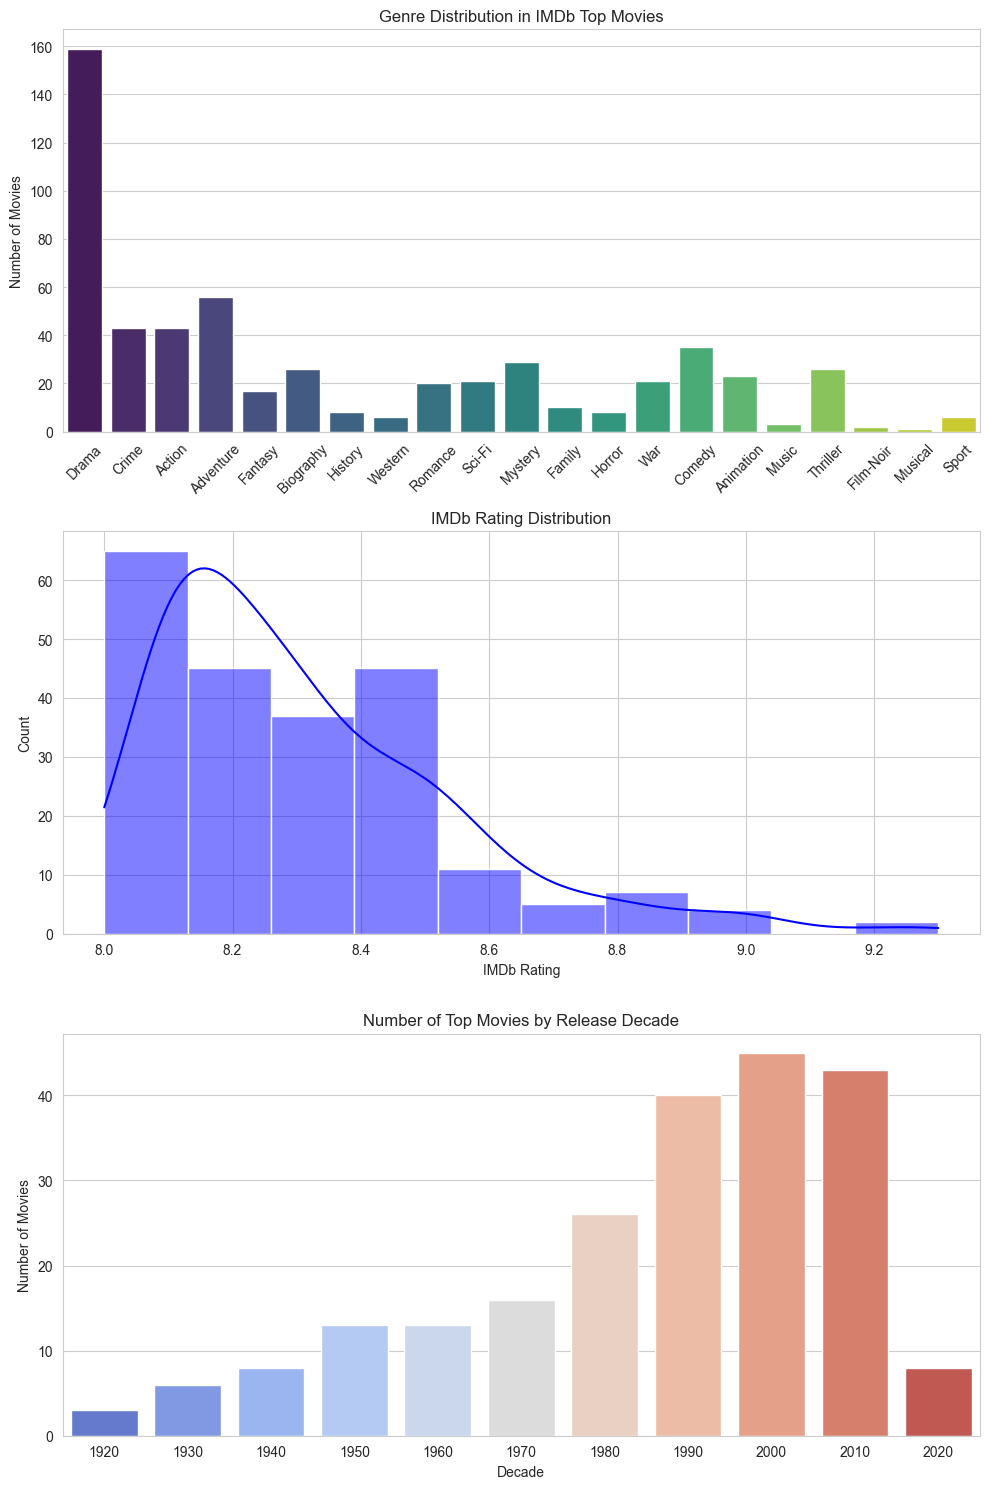

In [53]:

# Set visualization style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# 1. Genre Distribution
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()), ax=axes[0], palette="viridis")
axes[0].set_title("Genre Distribution in IMDb Top Movies")
axes[0].set_ylabel("Number of Movies")
axes[0].tick_params(axis='x', rotation=45)

# 2. IMDb Rating Distribution
sns.histplot(cleaned_reformed["rating"], bins=10, kde=True, ax=axes[1], color="blue")
axes[1].set_title("IMDb Rating Distribution")
axes[1].set_xlabel("IMDb Rating")
axes[1].set_ylabel("Count")

# 3. Movie Release Decades
cleaned_reformed["release_decade"] = (cleaned_reformed["release_year"] // 10) * 10  # Group years into decades
decade_counts = cleaned_reformed["release_decade"].value_counts().sort_index()
sns.barplot(x=decade_counts.index.astype(str), y=decade_counts.values, ax=axes[2], palette="coolwarm")
axes[2].set_title("Number of Top Movies by Release Decade")
axes[2].set_xlabel("Decade")
axes[2].set_ylabel("Number of Movies")



# Adjust layout and display
plt.tight_layout()
plt.show()


### **Key Insights from IMDb Top Movies Analysis**  

 **1. Genre Distribution**  
   - **Drama** is the most dominant genre, appearing in most top-rated movies.  
   - Other frequently occurring genres include **Crime, Action, and Biography**, showing a preference for intense storytelling and real-life inspirations.  

 **2. IMDb Rating Distribution**  
   - The **average rating is 8.31**, indicating that IMDb's Top Movies are highly rated.  
   - Most movies have ratings between **8.0 and 9.0**, with very few falling below 8.0.  


 **3. Movie Release Decades**  
   - The **1990s and 2000s** produced the highest number of top-rated movies.  
   - Classic films from earlier decades (e.g., **1970s and 1980s**) still hold strong rankings.  
   - Recent decades (**2010s and 2020s**) have fewer movies in the Top List, possibly due to evolving audience preferences or ranking criteria.  



In [60]:
## sorting the data by release_year in descending order
Rate_sorted_data = cleaned_reformed.sort_values(by='rating',ascending=False)
Rate_sorted_data.head(6)

,title,genres,release_year,movie_length,rating,vote_count,Synopsis,Cast (Main Actors),Box Office Gross,Awards,date,Release_Month_name,Release_week_day,release_decade
0,The Shawshank Redemption,Drama,1994,2:22:00,9.3,3020598,A banker convicted of uxoricide forms a friend...,"Tim Robbins, Morgan Freeman, Bob Gunton","$28,767,189",Nominated for 7 Oscars. 21 wins & 42 nominatio...,1994-10-14,October,Friday,1990
1,The Godfather,"Crime, Drama",1972,2:55:00,9.2,2108019,The aging patriarch of an organized crime dyna...,"Marlon Brando, Al Pacino, James Caan","$136,381,073",Won 3 Oscars. 31 wins & 31 nominations total,1972-03-24,March,Friday,1970
2,The Dark Knight,"Action, Crime, Drama",2008,2:32:00,9.0,2996913,When a menace known as the Joker wreaks havoc ...,"Christian Bale, Heath Ledger, Aaron Eckhart","$534,987,076",Won 2 Oscars. 164 wins & 165 nominations total,2008-07-18,July,Friday,2000
3,The Godfather Part II,"Crime, Drama",1974,3:22:00,9.0,1419714,The early life and career of Vito Corleone in ...,"Al Pacino, Robert De Niro, Robert Duvall","$47,834,595",Won 6 Oscars. 17 wins & 21 nominations total,1974-12-18,December,Wednesday,1970
4,The Lord of the Rings: The Return of the King,"Adventure, Drama, Fantasy",2003,3:21:00,9.0,2063799,Gandalf and Aragorn lead the World of Men agai...,"Elijah Wood, Viggo Mortensen, Ian McKellen","$381,878,219",Won 11 Oscars. 215 wins & 124 nominations total,2003-12-17,December,Wednesday,2000
5,Schindler's List,"Biography, Drama, History",1993,3:15:00,9.0,1512153,"In German-occupied Poland during World War II,...","Liam Neeson, Ralph Fiennes, Ben Kingsley","$96,898,818",Won 7 Oscars. 91 wins & 49 nominations total,1993-02-04,February,Thursday,1990


## **WEEK DAYS AND MONTHS IN WHICH MOVIES MOST RELEASED**

In [62]:
all_week_days = cleaned_reformed['Release_week_day'].dropna().str.split(', ').sum()
day_counts = Counter(all_week_days)

# Identify the most frequent genre
most_all_week_days = genre_counts.most_common(1)[0]
day_counts

Counter({'Friday': 102,
         'Wednesday': 52,
         'Thursday': 34,
         'Tuesday': 14,
         'Saturday': 9,
         'Monday': 7,
         'Sunday': 3})

- Graphically

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis')
wordcloud.generate_from_frequencies(day_counts)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('The IMDb ')
plt.show()